# Tree-Sparse Bayesian VAR with HMC/NUTS
This notebook estimates a tree-sparse Bayesian VAR model using Hamiltonian Monte Carlo (HMC/NUTS).
We:
1. Load data and define model parameters
2. Implement `log_prob` with tree projection inside the model
3. Use MAP estimation **only** as a warm start for HMC
4. Run HMC/NUTS to sample from the posterior
5. Analyze posterior edge inclusion probabilities
6. Include quick diagnostics for $Z$ and fitted vs observed series.


## 1. Setup & Data Loading
We import required libraries and load the dataset. Variables:
- `y`: Response time series (T x p)
- `X`: Lagged predictors (T x dp)
- `p`: Number of variables
- `d`: Number of lags
- `m`: Number of latent trees
- `t`: Temperature parameter for adjacency conversion

In [2]:
!pip install git+https://github.com/AdamCobb/hamiltorch

  Cloning https://github.com/AdamCobb/hamiltorch to /tmp/pip-req-build-2p94u6i5
  Running command git clone --filter=blob:none --quiet https://github.com/AdamCobb/hamiltorch /tmp/pip-req-build-2p94u6i5
  Resolved https://github.com/AdamCobb/hamiltorch to commit 19b627b2aabc77c1b4b78db0f860372eb1bf9778
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [3]:
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from pylab import rcParams
import torch
import math
from torch import nn
from torch import distributions
from torch.distributions import Beta
from torch.distributions import Exponential
from torch.distributions import HalfCauchy
from torch.distributions import Dirichlet
from torch.nn.parameter import Parameter
import pickle as pkl
import hamiltorch
import pandas as pd

In [4]:
# select device: change to 'cpu' if there's no GPU device
device = "cpu"

if device == 'gpu':
    torch.cuda.set_device(0)
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)

if device == 'cpu':
    torch.set_default_tensor_type(torch.DoubleTensor)

/usr/local/lib/python3.11/dist-packages/torch/__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [5]:
with open("time_series.pkl", "rb") as f:
    T, Y_all = pkl.load(f)

In [6]:
pk = (T>=0) & (T<1000)

Y= Y_all[:,pk]

p = Y.shape[0]

T = Y.shape[1]


In [7]:
def find_min_idx(x):
    k = x.argmin()
    ncol = x.shape[1]
    return int(k/ncol), k % ncol

def FindMST(A):
    p = A.shape[0]
    MST = np.zeros((p, p))

    Xl = list()
    Vl = list(range(p))
    Xl.append(0)
    Vl.remove(0)

    i = 0
    while len(Vl) > 0:
        idx0, idx1 = find_min_idx(A[Xl][:, Vl])

        MST[Xl[idx0], Vl[idx1]] = 1

        Xl.append(Vl[idx1])
        Vl.remove(Vl[idx1])

        i += 1

    return MST + MST.T

def findTopOrthogonalTree(C, m):

    C2Norm = np.zeros([p,p])

    for k in range(d):
        idx0 = k*p
        idx1 = idx0+p
        C2Norm+= C[idx0:idx1,:]**2

    mOrthogonalTrees  = np.zeros([p,p])

    treeList = list()

    for i in range(m):
        tree = FindMST( - C2Norm* (1-mOrthogonalTrees))
        mOrthogonalTrees+= tree
        treeList.append(tree)

    return mOrthogonalTrees, treeList

def projToTreeSparse(C, m):

    tree_covering, _ = findTopOrthogonalTree(C.cpu().numpy(), m)
    np.fill_diagonal(tree_covering,1)

    return C* np.tile(tree_covering, [d,1])

In [8]:
class TreeRankModel:
    def __init__(self, y,X, d = 5, m =5):
        self.y = y
        self.X = X
        self.d = d
        self.m = m
        self.N, self.p = y.shape

        self.C = torch.inverse(X.T@X + 10* torch.eye(d*p)) @ X.T@y

        Sigma = (y-X@self.C).T@(y-X@self.C)/(T-d)
        self.Omega = Sigma.inverse()

    def computeApproxMap(self, lr = 1E-7, steps=2000):
        Omega = self.Omega
        C = self.C
        m = self.m

        def loglik(C, Omega):
#             return ((y - X@C)@Omega@(y - X@C).T).sum()/2.0
            return ((y - X@C)**2).sum()/2.0

        def gradientLoglik(C, Omega):
#             return X.T@(X@C-y)@Omega
            return X.T@(X@C-y)


        C =  projToTreeSparse(C,m)

        for s in range(steps):
            C = C - lr * gradientLoglik(C,Omega)
            C = projToTreeSparse(C,m)

            if s%100==0:
                print(loglik(C,Omega))

        self.C = C


In [9]:
d=5

m=5

t=1.0/10

a1= 1 # parameter for s

a2=  1 # parameter for r

# lam = 0.1 # parameter for eta

df=pd.DataFrame(Y)

columns = df.columns.tolist()

columns = columns[::-1]

df = df[columns]

Yc=np.array(df)

f=Yc.T

y=f[0:T-d,]

x=f[1:T-d+1,]

for i in range(d-1):

    x=np.concatenate((x,f[i+2:T-d+i+2,]),axis=1)

X = torch.tensor(x,dtype=torch.double)

y = torch.tensor(y, dtype=torch.double)

In [10]:
m1 = TreeRankModel(y,X,d=5,m=5)

In [11]:
m1.computeApproxMap(steps=1000)

/tmp/ipython-input-4236754299.py:53: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return C* np.tile(tree_covering, [d,1])


tensor(618632.0165)
tensor(128629.6098)
tensor(94555.5436)
tensor(78673.6006)
tensor(70307.5447)
tensor(62279.4689)
tensor(56824.0198)
tensor(52636.6028)
tensor(49418.9603)
tensor(46755.4002)


In [12]:
C = m1.C

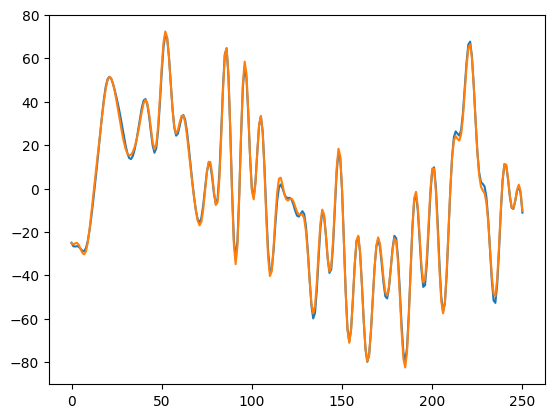

In [13]:
plt.plot(y[:,10])

plt.plot((X@C)[:,10])

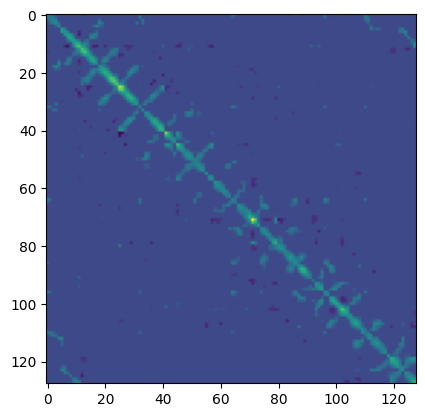

In [14]:
plt.imshow(C[:p,])

In [15]:
def GetA(W): # get weighted adjacency matrix A given weight W

#     W1 = torch.transpose(W,0,2)
#     W1 = torch.transpose(W1,1,2)

    X = torch.exp(W)

    X_ltri = torch.tril(X,diagonal=-1)

    A = X_ltri + torch.transpose(X_ltri,1,2)

    L = torch.diag_embed(A.sum(1))-A

    L_inv = torch.inverse(L+ 1.0/p**2 + torch.eye(p)*1E-12)

    L_inv_diag = torch.diagonal(L_inv,dim1=1,dim2=2).reshape([m,p,1])

    prob = -(2* L_inv - L_inv_diag - torch.transpose(L_inv_diag,1,2))*A

    return prob

In [16]:
num= d*p**2 + p*p*m +m  + d +1

## 1. Setup & Data Loading
We import required libraries and load the dataset. Variables:
- `y`: Response time series (T x p)
- `X`: Lagged predictors (T x dp)
- `p`: Number of variables
- `d`: Number of lags
- `m`: Number of latent trees
- `t`: Temperature parameter for adjacency conversion

In [17]:
from torch.nn.functional import softplus

from torch.nn.functional import logsigmoid

def log_jacobian_sigmoid(x):
    return x - 2.0* softplus(x)

def log_jacobian_softplus(x):
    return logsigmoid(x).sum()


def log_jacobian_softmax(x):
    return (x - torch.logsumexp(x,dim=0) + torch.log(1.0 - torch.nn.functional.softmax(x,dim=0))).sum()

In [18]:
def transformParams(params):
    prior_Sigma  = torch.eye(p)

    pd2=torch.zeros(1) # prior density for C
    logJacobian=torch.zeros(1) # prior density for C

    idx0 =0
    idx1 = d*p**2

    # c0 is the double exponential 1
    # c is c0 * scale
    c0 = params[idx0:idx1].reshape([d*p,p])

    # use sigmoid to make expW in (0,1)
    idx0 = idx1
    idx1 += p*p*m
    w0 = params[idx0:idx1].reshape([m,p,p])
    W =  torch.log(torch.sigmoid(w0))

    logJacobian += log_jacobian_sigmoid(w0).sum()  #jacobian of changing W to w0
    logJacobian += (0.1-1)*log_jacobian_sigmoid(w0).sum() # Beta prior (0.1,0.1)

    idx0 =idx1
    idx1 += m
    s=params[idx0:idx1]


    ss=  torch.nn.functional.softmax(s, dim = 0)  # softmax parametization of s
    logJacobian += log_jacobian_softmax(s)

    idx0 =idx1
    idx1 += d

    r=params[idx0:idx1]
    rr=  softplus(r) #torch.nn.functional.softmax(r, dim = 0)  # softmax parametization of r
    logJacobian += log_jacobian_softplus(r)
#     rr = torch.ones(d)


    # use softplus to make lam positive
    idx0 = idx1
    idx1 += 1
    lam0 = params[idx0:idx1]
    lam = torch.tensor(1.0)

    Z=torch.zeros([p,p])

    probMat = GetA(W/t)

    for i in range(m):
        Z+=ss[i]*probMat[i,:,:]

    Z+= torch.eye(p)*(1./m)

    scale =  torch.ones([d*p,p])
    for k in range(d):

        idx0 = k*p
        idx1 = idx0+p
        scale[idx0:idx1] = Z* torch.sqrt(rr[k]) + 1E-5

    logJacobian+= -torch.log(scale*lam).sum() # jacobian

    c = c0 * (scale*lam)

    return([c,W,ss,rr,lam,scale,c0,Z, logJacobian])


## 2. Model Definition – log_prob
The `log_prob` function computes the log posterior:
1. Unpacks the parameter vector
2. Applies transforms (`softplus`, `sigmoid`) to enforce constraints
3. Projects raw $W$ to a tree-sparse matrix using `projToTreeSparse`
4. Builds $Z$ (weighted adjacency matrix across $m$ trees)
5. Scales regression coefficients `c` using $Z$, `rr`, and `lam`
6. Computes the likelihood after integrating out the error covariance
Tree projection **inside** ensures sparsity in MAP and posterior samples.

In [19]:
def log_prob(params):

    prior_Sigma  = torch.eye(p)


    c,W,ss,rr,lam,scale,c0,Z, logJacobian = transformParams(params)


    # generalied double pareto with alpha=3
    pd2=  -4* torch.log(1+c0.abs()).sum()#-c0.abs().sum()

    pd3 = -0.5*(T-d+ p *0.2)*torch.logdet((y-X@c).T@(y-X@c)+ prior_Sigma*1E-1  ) # density after intergrating over Sigma LKJ Uniform prior

    pd4 = (a1-1)*(torch.log(ss)).sum()  # controls s_i cannot be too small

    pd5 = (-(2.0+1)* torch.log(rr) - 1.0/rr).sum() #(a2-1)*(torch.log(rr)).sum()-(r*r).sum()/18.0 # controls r_i cannot be too small

    pd6 = (-(2.0+1)* torch.log(lam*lam) - 1.0/(lam*lam)).sum() #-torch.log(1 + lam**2)

    return pd2+pd3+pd4+pd5+pd6 + logJacobian

In [20]:
theta = (torch.ones([num]))

In [21]:
# proper initialization

W = torch.tensor(-np.abs(np.log(0.01+ 0.98* np.stack(findTopOrthogonalTree(C.numpy(),m)[1]))))

theta[(d*p**2):(d*p**2 + m*p*p)] = W.flatten()

_,_,_,_,lam,scale,_,_, _ = transformParams(theta)

c0 = (C/(lam*scale)).flatten().detach()

theta[:(d*p**2)]=c0

In [22]:
log_prob(theta)

tensor([799437.1053])

## 3. MAP Warm Start
We run a short MAP optimization to get `theta_map` as a starting point for HMC/NUTS.
We do **not** analyze MAP estimates here — MAP is just an initial value.

In [23]:
theta = theta.requires_grad_()

log_prob(theta)

optimizer = torch.optim.Adam([theta], lr=1E-5)

for i in range(2000):

    loss =  -log_prob(theta)

    if i%100==0:

        print(i,  loss)

#         print(theta)

    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward(retain_graph=True)

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()


0 tensor([-799437.1053], grad_fn=<NegBackward0>)
100 tensor([-799960.2380], grad_fn=<NegBackward0>)
200 tensor([-800889.4401], grad_fn=<NegBackward0>)
300 tensor([-801540.4588], grad_fn=<NegBackward0>)
400 tensor([-801935.0923], grad_fn=<NegBackward0>)
500 tensor([-802203.7382], grad_fn=<NegBackward0>)
600 tensor([-802472.4155], grad_fn=<NegBackward0>)
700 tensor([-802809.6098], grad_fn=<NegBackward0>)
800 tensor([-803284.3587], grad_fn=<NegBackward0>)
900 tensor([-803611.8397], grad_fn=<NegBackward0>)
1000 tensor([-803885.5805], grad_fn=<NegBackward0>)
1100 tensor([-804137.1149], grad_fn=<NegBackward0>)
1200 tensor([-804346.7499], grad_fn=<NegBackward0>)
1300 tensor([-804541.4585], grad_fn=<NegBackward0>)
1400 tensor([-804733.2517], grad_fn=<NegBackward0>)
1500 tensor([-804930.0582], grad_fn=<NegBackward0>)
1600 tensor([-805139.9017], grad_fn=<NegBackward0>)
1700 tensor([-805377.3526], grad_fn=<NegBackward0>)
1800 tensor([-805640.4560], grad_fn=<NegBackward0>)
1900 tensor([-805883.313

In [24]:
log_prob(theta)

tensor([806116.2885], grad_fn=<AddBackward0>)

In [25]:
inv_mass_all = torch.ones(num)
inv_mass_C = torch.ones(num)*1E-10
inv_mass_W = torch.ones(num)*1E-10
inv_mass_others = torch.ones(num)*1E-10

In [26]:
inv_mass_C[:(d*p**2)] =1
inv_mass_W[(d*p**2):(d*p**2+ m*p*p)] =1
inv_mass_others[(d*p**2+ m*p*p):]=1

In [27]:
import io
from contextlib import redirect_stdout


## 4. HMC/NUTS Sampling
We use `hamiltorch` to run HMC/NUTS with `theta_map` as initialization.
Important arguments:
- `num_samples`: Number of posterior draws
- `step_size`: Leapfrog step size
- `desired_accept_rate`: Target acceptance rate
- `inv_mass`: Mass matrix (diagonal)

In [28]:
def blockHMC(theta, step_size, inv_mass, num_samples = 30, L = 1):
    burn = 0
    params_hmc_nuts = hamiltorch.sample(log_prob_func=log_prob,
                                    params_init=theta, num_samples=num_samples,
                                    step_size=step_size, num_steps_per_sample=L,
                                    desired_accept_rate=0.7,
                                    sampler=hamiltorch.Sampler.HMC,burn=burn,
                                    inv_mass = inv_mass
                                   )
    theta1 = params_hmc_nuts[len(params_hmc_nuts)-1].clone()

    return  params_hmc_nuts, theta1

In [29]:
step_size = 1E-2
inv_mass_all[:(d*p**2)]=5E-5
inv_mass_all[(d*p**2):(d*p**2+ m*p*p)] =1E-2
inv_mass_all[(d*p**2+ m*p*p):]=1E-5
L=20

## 4. HMC/NUTS Sampling
We use `hamiltorch` to run HMC/NUTS with `theta_map` as initialization.
Important arguments:
- `num_samples`: Number of posterior draws
- `step_size`: Leapfrog step size
- `desired_accept_rate`: Target acceptance rate
- `inv_mass`: Mass matrix (diagonal)

In [30]:
burn = 100
num_samples = 500

params_hmc_nuts = hamiltorch.sample(log_prob_func=log_prob,
                                params_init=theta, num_samples=num_samples,
                                step_size=step_size, num_steps_per_sample=L,
                                desired_accept_rate=0.7,
                                sampler=hamiltorch.Sampler.HMC_NUTS,burn=burn,
                                inv_mass = inv_mass_all
                               )

theta = params_hmc_nuts[len(params_hmc_nuts)-1]

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Final Adapted Step Size:  0.007277100812643766

Acceptance Rate 0.80


In [31]:
params=theta.clone()

c,W,ss,rr,lam,scale,c0,Z, logJacobian = transformParams(params)

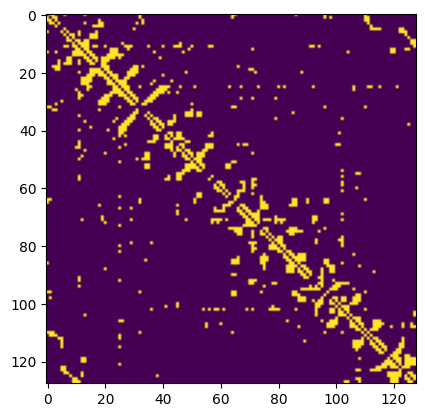

In [32]:
plt.imshow(findTopOrthogonalTree(C.numpy(),m)[0])


## 6. Quick Diagnostics
We visualize:
- $Z$ absolute values heatmap for a given sample
- Observed vs fitted time series for one variable.
This helps check if the model's fit is reasonable.

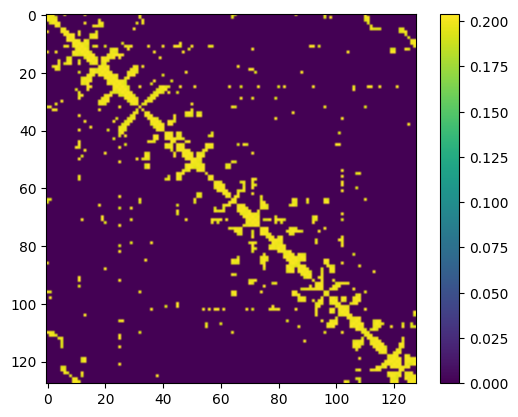

In [33]:
plt.imshow(Z.detach().abs().numpy())
plt.colorbar()

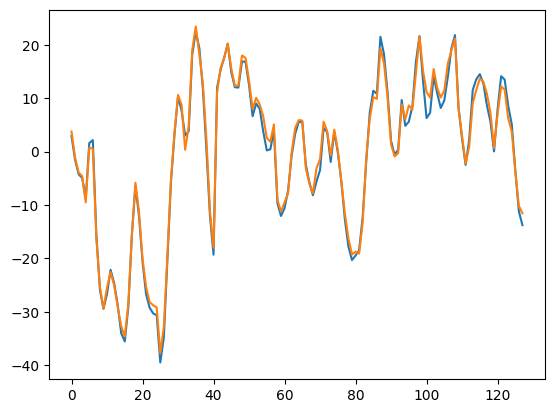

In [34]:
plt.plot(y[2])
plt.plot((X@c).detach().numpy()[2])